In [2]:

import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import xarray as xr
import matplotlib.pyplot as plt
from shapely.geometry import Point
from scipy.interpolate import griddata
from rasterio.transform import from_origin

In [3]:
ec_data = pd.read_excel("../Data/ec_data/2024_TAPS_Veris_raw_spatial_data.xlsx")
geometry = [Point(xy) for xy in zip(ec_data['Long'], ec_data['Lat'])]

# Create a GeoDataFrame
ec_vector_data = gpd.GeoDataFrame(ec_data, geometry=geometry)
ec_vector_data.set_crs("EPSG:4326", inplace=True) 
ec_vector_data.to_file('EC_vector_file.geojson', driver="GeoJSON")

#Interpolating the data
points = np.array(list(zip(ec_vector_data.geometry.x, ec_vector_data.geometry.y)))
ec_shallow = ec_vector_data['EC SH'].values
ec_deep = ec_vector_data['EC DP'].values

#Define grid parameters
x_min, x_max = points[:, 0].min(), points[:, 0].max()
y_min, y_max = points[:, 1].min(), points[:, 1].max()
grid_x, grid_y = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]

#Interpolate data to the grid
grid_z_shallow = griddata(points, ec_shallow, (grid_x, grid_y), method='cubic') #cubic interpolation
grid_z_deep = griddata(points, ec_deep, (grid_x, grid_y), method='cubic') #cubic interpolation


In [4]:
ec_raster_shallow = xr.open_dataarray("interpolated_raster_EC_shallow.tif") 
with rasterio.open('Interpolated_raster_EC_deep.tif', 'w', driver= 'GTiff', 
                   height= grid_z_deep.shape[0], width= grid_z_deep.shape[1],
                   count= 1, crs = "EPSG:4326", dtype= grid_z_deep.dtype,
                   transform = from_origin(x_min, y_max, (x_max - x_min) /100 , (y_max - y_min) /100)) as dst:
    dst.write(grid_z_deep,1)

ec_raster_deep = xr.open_dataarray("interpolated_raster_EC_deep.tif") 


#Clipping the EC values by plt boundary
plot_boundary = gpd.read_file("../Data/plot_boundaries/Map with all plots/2024_Colby_TAPS_Harvest_Area.shx")


#Define function for cliping raster file to tuttle creek
clip_fn = lambda polygon, R: R.rio.clip( [polygon.geometry], 
                                        crs = R.rio.crs,
                                        all_touched = True)

plot_boundary['EC_shallow'] = plot_boundary.apply(lambda row: clip_fn(row,ec_raster_shallow), axis =1)

plot_boundary['EC_deep'] = plot_boundary.apply(lambda row: clip_fn(row,ec_raster_deep), axis =1)


In [5]:
plot_boundary.head()

,Name,Block_ID,TRT_ID,Plot_ID,geometry,EC_shallow,EC_deep
0,Span D,1,15,2502,"POLYGON ((-101.06572 39.387, -101.06572 39.386...",[[[<xarray.DataArray 'band_data' ()> Size: 8B\...,[[[<xarray.DataArray 'band_data' ()> Size: 8B\...
1,Span A,4,27,204,"POLYGON ((-101.06495 39.38511, -101.06495 39.3...",[[[<xarray.DataArray 'band_data' ()> Size: 8B\...,[[[<xarray.DataArray 'band_data' ()> Size: 8B\...
2,Span A,4,30,206,"POLYGON ((-101.06417 39.38511, -101.06417 39.3...",[[[<xarray.DataArray 'band_data' ()> Size: 8B\...,[[[<xarray.DataArray 'band_data' ()> Size: 8B\...
3,Span A,4,2,205,"POLYGON ((-101.06456 39.38511, -101.06456 39.3...",[[[<xarray.DataArray 'band_data' ()> Size: 8B\...,[[[<xarray.DataArray 'band_data' ()> Size: 8B\...
4,Span A,2,14,203,"POLYGON ((-101.06534 39.38512, -101.06534 39.3...",[[[<xarray.DataArray 'band_data' ()> Size: 8B\...,[[[<xarray.DataArray 'band_data' ()> Size: 8B\...


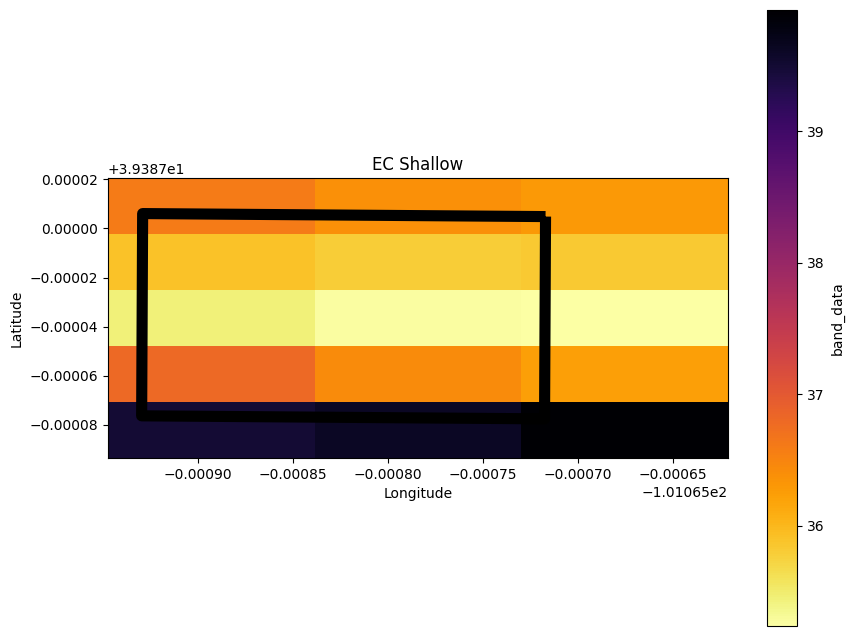

In [ ]:
#Plotting the EC values 
fig,ax = plt.subplots(figsize = (10,8))
plot_boundary.loc[ [0], 'geometry'].boundary.plot(ax=ax, edgecolor = 'k', linewidth=8)
plot_boundary.loc[0, 'EC_shallow'].plot(ax=ax, cmap='inferno_r')
ax.set_title('EC Shallow')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude') 
plt.show()


import plotly.graph_objects as go
import numpy as np
import xarray as xr

# Set up Plotly figure
fig = go.Figure()

# Convert boundary data to list to make it compatible with Plotly
boundary_x, boundary_y = map(list, plot_boundary.loc[0, 'geometry'].boundary.xy)
fig.add_trace(go.Scatter(x=boundary_x, y=boundary_y, mode='lines', line=dict(color='black', width=3), name='Boundary'))

# Generate EC_shallow data by applying the clip function and extracting the NumPy array
ec_shallow_data = plot_boundary.apply(
    lambda row: clip_fn(row, ec_raster_shallow).values if isinstance(clip_fn(row, ec_raster_shallow), xr.DataArray) 
    else clip_fn(row, ec_raster_shallow), 
    axis=1
)

# Flatten each array in ec_shallow_data if necessary
ec_shallow_data_flattened = [np.array(data).flatten() if isinstance(data, (np.ndarray, list)) else np.array([data]) for data in ec_shallow_data]

# Pad or reshape to ensure each entry has the same length
max_length = max(len(data) for data in ec_shallow_data_flattened)
ec_shallow_data_padded = np.array([np.pad(data, (0, max_length - len(data)), mode='constant', constant_values=np.nan) for data in ec_shallow_data_flattened])

# Plot the EC_shallow data as a heatmap
fig.add_trace(go.Heatmap(
    z=ec_shallow_data_padded,
    colorscale='Inferno',
    name='EC Shallow',
    colorbar=dict(title='EC Value')
))

# Update layout with title and axis labels
fig.update_layout(
    title='EC Shallow',
    xaxis_title='Longitude',
    yaxis_title='Latitude',
    xaxis=dict(scaleanchor="y", scaleratio=1),
)

# Show plot
fig.show()


In [6]:
import plotly.graph_objects as go
import numpy as np
import xarray as xr

# Set up Plotly figure
fig = go.Figure()

# Convert boundary data to list to make it compatible with Plotly
boundary_x, boundary_y = map(list, plot_boundary.loc[0, 'geometry'].boundary.xy)
fig.add_trace(go.Scatter(x=boundary_x, y=boundary_y, mode='lines', line=dict(color='black', width=3), name='Boundary'))

# Generate EC_shallow data by applying the clip function and extracting the NumPy array
ec_shallow_data = plot_boundary.apply(
    lambda row: clip_fn(row, ec_raster_shallow).values if isinstance(clip_fn(row, ec_raster_shallow), xr.DataArray) 
    else clip_fn(row, ec_raster_shallow), 
    axis=1
)

# Convert ec_shallow_data to a 2D NumPy array for Heatmap plotting, if necessary
ec_shallow_data_flattened = [np.array(data).flatten() if isinstance(data, (np.ndarray, list)) else np.array([data]) for data in ec_shallow_data]
max_length = max(len(data) for data in ec_shallow_data_flattened)
ec_shallow_data_padded = np.array([np.pad(data, (0, max_length - len(data)), mode='constant', constant_values=np.nan) for data in ec_shallow_data_flattened])

# Plot the EC_shallow data as a heatmap
fig.add_trace(go.Heatmap(
    z=ec_shallow_data_padded,
    colorscale='Inferno',
    name='EC Shallow',
    colorbar=dict(title='EC Value'),
    x=boundary_x,  # Use boundary_x as longitude
    y=boundary_y   # Use boundary_y as latitude
))

# Set the axis range to zoom in on the specific area of interest
fig.update_xaxes(range=[min(boundary_x), max(boundary_x)])
fig.update_yaxes(range=[min(boundary_y), max(boundary_y)])

# Update layout with title and axis labels
fig.update_layout(
    title='EC Shallow',
    xaxis_title='Longitude',
    yaxis_title='Latitude',
    xaxis=dict(scaleanchor="y", scaleratio=1),
)

# Show plot
fig.show()


In [7]:
import plotly.graph_objects as go
import numpy as np
import xarray as xr

# Set up Plotly figure
fig = go.Figure()

# Convert boundary data to list to make it compatible with Plotly
boundary_x, boundary_y = map(list, plot_boundary.loc[0, 'geometry'].boundary.xy)
fig.add_trace(go.Scatter(x=boundary_x, y=boundary_y, mode='lines', line=dict(color='black', width=3), name='Boundary'))

# Generate EC_shallow data by applying the clip function and extracting the NumPy array
ec_shallow_data = plot_boundary.apply(
    lambda row: clip_fn(row, ec_raster_shallow).values if isinstance(clip_fn(row, ec_raster_shallow), xr.DataArray) 
    else clip_fn(row, ec_raster_shallow), 
    axis=1
)

# Convert ec_shallow_data to a 2D NumPy array for Heatmap plotting, if necessary
ec_shallow_data_flattened = [np.array(data).flatten() if isinstance(data, (np.ndarray, list)) else np.array([data]) for data in ec_shallow_data]

# Calculate aspect ratio based on boundary extents
lon_min, lon_max = min(boundary_x), max(boundary_x)
lat_min, lat_max = min(boundary_y), max(boundary_y)
aspect_ratio = (lat_max - lat_min) / (lon_max - lon_min)

# Reshape or resize ec_shallow_data to fit within the extent
ec_shallow_data_resized = np.array([np.resize(data, (int(len(data) * aspect_ratio), len(data))) for data in ec_shallow_data_flattened])

# Plot the EC_shallow data as a heatmap with explicit coordinates
fig.add_trace(go.Heatmap(
    z=ec_shallow_data_resized,
    colorscale='Inferno',
    name='EC Shallow',
    colorbar=dict(title='EC Value'),
    x=np.linspace(lon_min, lon_max, ec_shallow_data_resized.shape[1]),  # Longitude range
    y=np.linspace(lat_min, lat_max, ec_shallow_data_resized.shape[0])   # Latitude range
))

# Set the axis range to zoom in on the specific area of interest
fig.update_xaxes(range=[lon_min, lon_max])
fig.update_yaxes(range=[lat_min, lat_max])

# Update layout with title and axis labels
fig.update_layout(
    title='EC Shallow',
    xaxis_title='Longitude',
    yaxis_title='Latitude',
    xaxis=dict(scaleanchor="y", scaleratio=1),
)

# Show plot
fig.show()


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (138,) + inhomogeneous part.